### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 613 (delta 110), reused 221 (delta 57), pack-reused 278
Receiving objects: 100% (613/613), 97.28 MiB | 36.99 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=5a8d6895297837c5511a9b29e39d5fc5ed14b128a98e8480f7fd54a4796ea5cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-zoow2pp5/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

     |████████████████████████████████| 440kB 16.9MB/s 


In [6]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, EqualHist
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet50
# Pipeline: EqualHist, Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet_eqhist.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/5
85/85 [==============================] - 14s 50ms/step - loss: 0.3472 - accuracy: 0.8694 - val_loss: 0.1350 - val_accuracy: 0.9597
Epoch 2/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0763 - accuracy: 0.9730 - val_loss: 0.1219 - val_accuracy: 0.9607
Epoch 3/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.1187 - val_accuracy: 0.9682
Epoch 4/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0365 - accuracy: 0.9904 - val_loss: 0.1142 - val_accuracy: 0.9703
Epoch 5/5
85/85 [==============================] - 2s 29ms/step - loss: 0.0257 - accuracy: 0.9942 - val_loss: 0.1084 - val_accuracy: 0.9703


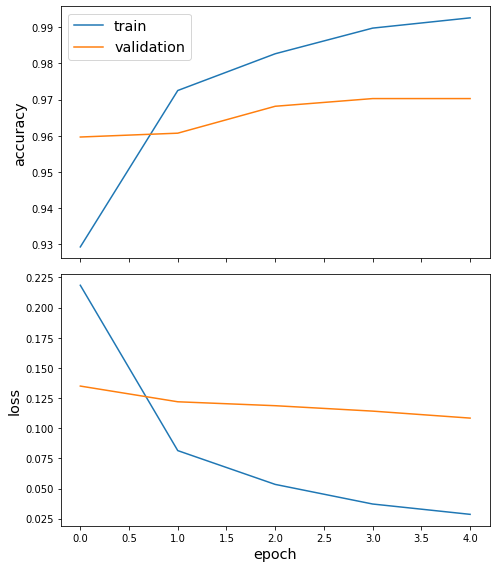

In [11]:
plot_history(history)

### Validation

In [12]:
del data

In [13]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        EqualHist(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.9; nms_overlap=0.4

In [14]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/eqhist/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt


  2%|▏         | 1/66 [00:03<03:18,  3.05s/it]

22


  3%|▎         | 2/66 [00:04<02:48,  2.63s/it]

7


  5%|▍         | 3/66 [00:06<02:26,  2.33s/it]

11


  6%|▌         | 4/66 [00:07<02:11,  2.12s/it]

15


  8%|▊         | 5/66 [00:09<02:00,  1.97s/it]

17


  9%|▉         | 6/66 [00:11<01:51,  1.87s/it]

13


 11%|█         | 7/66 [00:12<01:46,  1.80s/it]

27


 12%|█▏        | 8/66 [00:14<01:41,  1.75s/it]

26


 14%|█▎        | 9/66 [00:16<01:37,  1.71s/it]

24


 15%|█▌        | 10/66 [00:17<01:34,  1.70s/it]

68


 17%|█▋        | 11/66 [00:19<01:31,  1.67s/it]

10


 18%|█▊        | 12/66 [00:20<01:28,  1.65s/it]

74


 20%|█▉        | 13/66 [00:22<01:27,  1.64s/it]

21


 21%|██        | 14/66 [00:24<01:25,  1.64s/it]

24


 23%|██▎       | 15/66 [00:25<01:23,  1.64s/it]

17


 24%|██▍       | 16/66 [00:27<01:21,  1.63s/it]

24


 26%|██▌       | 17/66 [00:29<01:20,  1.65s/it]

34


 27%|██▋       | 18/66 [00:30<01:19,  1.65s/it]

12


 29%|██▉       | 19/66 [00:32<01:17,  1.64s/it]

20


 30%|███       | 20/66 [00:34<01:15,  1.65s/it]

15


 32%|███▏      | 21/66 [00:35<01:14,  1.64s/it]

16


 33%|███▎      | 22/66 [00:37<01:12,  1.64s/it]

18


 35%|███▍      | 23/66 [00:39<01:11,  1.65s/it]

124


 36%|███▋      | 24/66 [00:40<01:09,  1.65s/it]

21


 38%|███▊      | 25/66 [00:42<01:07,  1.65s/it]

8


 39%|███▉      | 26/66 [00:44<01:06,  1.66s/it]

22


 41%|████      | 27/66 [00:45<01:04,  1.66s/it]

41


 42%|████▏     | 28/66 [00:47<01:03,  1.66s/it]

32


 44%|████▍     | 29/66 [00:48<01:01,  1.66s/it]

7


 45%|████▌     | 30/66 [00:50<00:59,  1.65s/it]

4


 47%|████▋     | 31/66 [00:52<00:57,  1.65s/it]

46


 48%|████▊     | 32/66 [00:53<00:55,  1.65s/it]

10


 50%|█████     | 33/66 [00:55<00:54,  1.65s/it]

6


 52%|█████▏    | 34/66 [00:57<00:52,  1.64s/it]

12


 53%|█████▎    | 35/66 [00:58<00:51,  1.66s/it]

34


 55%|█████▍    | 36/66 [01:00<00:49,  1.67s/it]

14


 56%|█████▌    | 37/66 [01:02<00:49,  1.72s/it]

6


 58%|█████▊    | 38/66 [01:04<00:47,  1.70s/it]

6


 59%|█████▉    | 39/66 [01:05<00:45,  1.68s/it]

25


 61%|██████    | 40/66 [01:07<00:43,  1.67s/it]

9


 62%|██████▏   | 41/66 [01:09<00:41,  1.66s/it]

5


 64%|██████▎   | 42/66 [01:10<00:39,  1.66s/it]

32


 65%|██████▌   | 43/66 [01:12<00:38,  1.67s/it]

52


 67%|██████▋   | 44/66 [01:14<00:36,  1.67s/it]

12


 68%|██████▊   | 45/66 [01:15<00:35,  1.67s/it]

4


 70%|██████▉   | 46/66 [01:17<00:33,  1.67s/it]

11


 71%|███████   | 47/66 [01:19<00:31,  1.67s/it]

12


 73%|███████▎  | 48/66 [01:20<00:30,  1.68s/it]

40


 74%|███████▍  | 49/66 [01:22<00:28,  1.69s/it]

69


 76%|███████▌  | 50/66 [01:24<00:26,  1.68s/it]

22


 77%|███████▋  | 51/66 [01:25<00:25,  1.67s/it]

4


 79%|███████▉  | 52/66 [01:27<00:23,  1.66s/it]

21


 80%|████████  | 53/66 [01:29<00:21,  1.66s/it]

11


 82%|████████▏ | 54/66 [01:30<00:19,  1.66s/it]

21


 83%|████████▎ | 55/66 [01:32<00:18,  1.66s/it]

49


 85%|████████▍ | 56/66 [01:34<00:16,  1.66s/it]

23


 86%|████████▋ | 57/66 [01:35<00:14,  1.66s/it]

2


 88%|████████▊ | 58/66 [01:37<00:13,  1.65s/it]

14


 89%|████████▉ | 59/66 [01:38<00:11,  1.66s/it]

33


 91%|█████████ | 60/66 [01:40<00:09,  1.65s/it]

12


 92%|█████████▏| 61/66 [01:42<00:08,  1.66s/it]

5


 94%|█████████▍| 62/66 [01:44<00:06,  1.67s/it]

30


 95%|█████████▌| 63/66 [01:45<00:04,  1.66s/it]

14


 97%|█████████▋| 64/66 [01:47<00:03,  1.66s/it]

17


 98%|█████████▊| 65/66 [01:48<00:01,  1.66s/it]

10


100%|██████████| 66/66 [01:50<00:00,  1.68s/it]

22



Precision: 0.073
Recall: 0.835
F1Score: 0.135
